## A Plan to change samples

Consider we have some measurement technique defined in a plan. We might want to change a sample between each



## Setup the Bluesky test environment

In [3]:
#configure a temp run engine environment

from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)


1

## Create a plan which selects samples



In [1]:
from ophyd.sim import motor1 as sample_robot
import  bluesky.plan_stubs as bps


def select_sample(sample_id):
    """ 
    A plan which takes as argument a sample ID
    and then fetches that sample

    Parameters
    ----------
    sample_id: integer
        The id of the sample we will select
    """

    # Note that we can refer to a particular ophyd device within the plan
    # Sometimes this is useful 
    return bps.mv(sample_robot, sample_id)




## Create a plan which will measure with a technique at a number of samples






Transient Scan ID: 11     Time: 2023-10-31 18:46:31
Persistent Unique Scan ID: '7282c8c4-2291-4be2-be32-ed5746889ff6'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |  noisy_det |
+-----------+------------+------------+
|         1 | 18:46:31.2 |      0.975 |
|         2 | 18:46:31.2 |      0.930 |
|         3 | 18:46:31.2 |      1.037 |
|         4 | 18:46:31.3 |      1.025 |
|         5 | 18:46:31.3 |      1.078 |
|         6 | 18:46:31.3 |      0.926 |
|         7 | 18:46:31.4 |      0.942 |
|         8 | 18:46:31.4 |      1.048 |
|         9 | 18:46:31.4 |      1.069 |
|        10 | 18:46:31.5 |      1.049 |
+-----------+------------+------------+
generator count ['7282c8c4'] (scan num: 11)





Transient Scan ID: 12     Time: 2023-10-31 18:46:31
Persistent Unique Scan ID: 'c2de55f5-76b3-490e-815c-493558adef3a'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |  noisy_det |
+-----------+------------+---

('7282c8c4-2291-4be2-be32-ed5746889ff6',
 'c2de55f5-76b3-490e-815c-493558adef3a',
 '6ae82bbd-4b57-404f-ad02-f8cbe924c401',
 '90d407b3-f847-4e00-b793-95f3a2c2f9f1',
 '9441ad80-1857-4f22-91e5-f79e86d51be2')

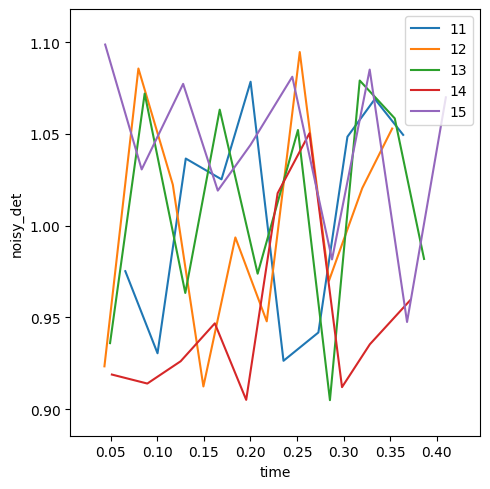

In [14]:
from bluesky.plans import count
from ophyd.sim import noisy_det
from bluesky.utils import new_uid

samples = [1,4,2,6,7]

def measure(samples):

    """
    A plan which will take a measurement for each sample in the list samples

    Parameters
    ----------
    samples: list of int
        a list of the samples to measure
    """

    # Generate a UID that we can use to tie all of these measurements together

    set_id = new_uid()

    for sample in samples:

        yield from select_sample(sample)

        yield from count([noisy_det],10,md={"sample_id":sample, "set_id":set_id})


RE(measure(samples))



## Let's look at the Data

We added some extra stuff into the metadata which let's us find it again later

In [30]:
run = db[-1]

run.metadata['start']

Start({'detectors': ['noisy_det'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'num_intervals': 9,
 'num_points': 10,
 'plan_args': {'detectors': ["SynGauss(prefix='', name='noisy_det', "
                             "read_attrs=['val'], configuration_attrs=['Imax', "
                             "'center', 'sigma', 'noise', "
                             "'noise_multiplier'])"],
               'num': 10},
 'plan_name': 'count',
 'plan_type': 'generator',
 'sample_id': 7,
 'scan_id': 15,
 'set_id': '0293e90a-32aa-4288-a9d3-4a81d9d6403d',
 'time': 1698774393.3744795,
 'uid': '9441ad80-1857-4f22-91e5-f79e86d51be2',
 'versions': {'bluesky': '1.11.0', 'ophyd': '1.9.0'}})

6ae82bbd-4b57-404f-ad02-f8cbe924c401
7282c8c4-2291-4be2-be32-ed5746889ff6
90d407b3-f847-4e00-b793-95f3a2c2f9f1
9441ad80-1857-4f22-91e5-f79e86d51be2
c2de55f5-76b3-490e-815c-493558adef3a


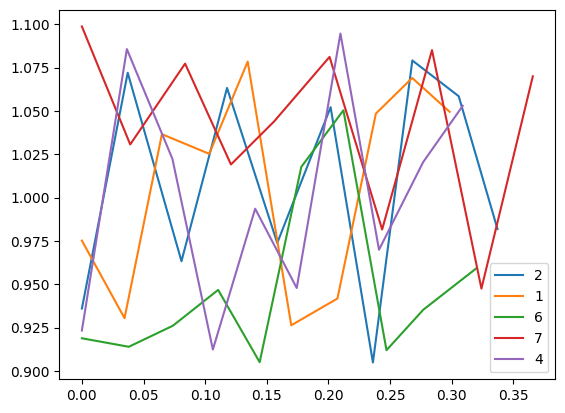

In [35]:
import matplotlib.pyplot as plt


#Find all the runs that were part of this set
set_id = run.metadata['start']['set_id']
results = db.search({"set_id":set_id})

for uid,run in results.items():

    print(uid)
    sample_id = run.metadata['start']["sample_id"]
    data = run.primary.read()
    y = data['noisy_det']
    x = data['time'] - data['time'][0]
    plt.plot(x,y, label=sample_id)
    plt.legend()

5